In [48]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from scipy import stats
from scipy import optimize
from scipy import spatial
import random

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

def pearson_r(x , y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size = 1):
    """Draw bootstrap replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

def draw_bs_pairs_linreg(x, y, size = 1):
    """perform pairs bootstrap for linear regression"""
    inds = np.arange(len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
    return bs_slope_reps, bs_intercept_reps

def draw_bs_pairs(x, y, func, size = 1):
    """Perform pairs bootstrap for a single statistic."""
    inds = np.arange(len(x))
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)
    return bs_replicates

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

def diff_frac(data_A, data_b):
    frac_A = np.sum(data_A) / len(data_A)
    frac_B = np.sum(data_B) / len(data_B)
    return frac_B - frac_A

def rmse(pred, obs):
    return np.sqrt(((pred - obs) ** 2).mean())

def mse(pred, obs):
    return ((pred - obs) ** 2).mean()

def bon_correct(alpha, n):
    return (alpha/n)

The goal of this project is to determine what factors of online learning may determine success.

In [3]:
eda_df = pd.read_csv('eda_stage.csv')

In [4]:
eda_df.shape

(534781, 24)

In [5]:
eda_df.head()

,id_student,gender,disability,age_band,region,imd_band,highest_education,id_site,code_module,code_presentation,id_assessment,date_registration,num_of_prev_attempts,final_result,studied_credits,date_submitted,score,assessment_type,module_presentation_length,weight,is_banked,activity_type,date,sum_click
0,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,forumng,19,1
1,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,forumng,19,1
2,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546614,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,homepage,19,10
3,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546876,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,subpage,19,2
4,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546871,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,subpage,19,1


In [6]:
eda_df['disability'].replace('No', 0, inplace = True)
eda_df['disability'].replace('Yes', 1, inplace = True)

eda_df['is_banked'].replace('No', 0, inplace = True)
eda_df['is_banked'].replace('Yes', 1, inplace = True)

C:\Users\jacob\AppData\Local\Temp\ipykernel_9960\1682318704.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eda_df['disability'].replace('No', 0, inplace = True)
C:\Users\jacob\AppData\Local\Temp\ipykernel_9960\1682318704.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [7]:
col_order = [x for x in eda_df.columns]

for c in col_order:
    print(c)
    print(eda_df[c].value_counts())
    print(eda_df[c].dtypes)
    print(eda_df[c].info)
    print()

id_student
id_student
2646317    1225
604879      648
556251      560
402449      550
308363      541
           ... 
683764        1
677167        1
226955        1
74165         1
635779        1
Name: count, Length: 16193, dtype: int64
int64
<bound method Series.info of 0         2412002
1         2412002
2         2412002
3         2412002
4         2412002
           ...   
534776     650630
534777     650630
534778     650630
534779     650630
534780     635779
Name: id_student, Length: 534781, dtype: int64>

gender
gender
Male      335073
Female    199708
Name: count, dtype: int64
object
<bound method Series.info of 0           Male
1           Male
2           Male
3           Male
4           Male
           ...  
534776      Male
534777      Male
534778      Male
534779      Male
534780    Female
Name: gender, Length: 534781, dtype: object>

disability
disability
0    493237
1     41544
Name: count, dtype: int64
int64
<bound method Series.info of 0         0
1         0
2    

In [8]:
eda_df.shape

(534781, 24)

In [9]:
df_dup_drop = eda_df.drop_duplicates()
df_dup_drop = df_dup_drop.reset_index(drop = True)
df_dup_drop.shape

(478940, 24)

In [10]:
df_dup_drop.head()

,id_student,gender,disability,age_band,region,imd_band,highest_education,id_site,code_module,code_presentation,id_assessment,date_registration,num_of_prev_attempts,final_result,studied_credits,date_submitted,score,assessment_type,module_presentation_length,weight,is_banked,activity_type,date,sum_click
0,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,0,forumng,19,1
1,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546614,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,0,homepage,19,10
2,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546876,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,0,subpage,19,2
3,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546871,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,0,subpage,19,1
4,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546879,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,0,subpage,19,3


In [11]:
df_no_id = df_dup_drop.drop('id_student', axis = 1)
df_no_id.head()

,gender,disability,age_band,region,imd_band,highest_education,id_site,code_module,code_presentation,id_assessment,date_registration,num_of_prev_attempts,final_result,studied_credits,date_submitted,score,assessment_type,module_presentation_length,weight,is_banked,activity_type,date,sum_click
0,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,0,forumng,19,1
1,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546614,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,0,homepage,19,10
2,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546876,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,0,subpage,19,2
3,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546871,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,0,subpage,19,1
4,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546879,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,0,subpage,19,3


Since I am simply looking into what determines pass or fail, all distinctions will be grouped with passes; and withdrawns will be dropped.

A new column will be added to make the pass/fail binary.

In [12]:
df_no_with = df_no_id[df_no_id['final_result'] != 'Withdrawn']
df_no_with.shape

(478805, 23)

In [13]:
df_no_with['pass'] = np.where(df_no_with['final_result'] == 'Fail', 0, 1)

C:\Users\jacob\AppData\Local\Temp\ipykernel_9960\2198708265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_with['pass'] = np.where(df_no_with['final_result'] == 'Fail', 0, 1)


In [14]:
df = df_no_with.drop(['final_result'], axis = 1)
df.head()

,gender,disability,age_band,region,imd_band,highest_education,id_site,code_module,code_presentation,id_assessment,date_registration,num_of_prev_attempts,studied_credits,date_submitted,score,assessment_type,module_presentation_length,weight,is_banked,activity_type,date,sum_click,pass
0,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,forumng,19,1,1
1,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546614,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,homepage,19,10,1
2,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546876,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,subpage,19,2,1
3,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546871,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,subpage,19,1,1
4,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546879,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,subpage,19,3,1


In [15]:
cat_col = df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output = False)
one_hot_encoded = encoder.fit_transform(df[cat_col])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(cat_col))
one_hot_df.head()

,gender_Female,gender_Male,age_band_0-35,age_band_35-55,age_band_55<=,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,imd_band_0-10%,imd_band_10-20%,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_presentation_2013B,code_presentation_2013J,code_presentation_2014B,code_presentation_2014J,assessment_type_CMA,assessment_type_Exam,assessment_type_TMA,activity_type_dataplus,activity_type_dualpane,activity_type_externalquiz,activity_type_folder,activity_type_forumng,activity_type_glossary,activity_type_homepage,activity_type_htmlactivity,activity_type_oucollaborate,activity_type_oucontent,activity_type_ouelluminate,activity_type_ouwiki,activity_type_page,activity_type_questionnaire,activity_type_quiz,activity_type_resource,activity_type_sharedsubpage,activity_type_subpage,activity_type_url
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
df_encoded = pd.concat([df, one_hot_df], axis = 1)
df_encoded = df_encoded.drop(cat_col, axis = 1)
df_encoded.shape

(478940, 80)

In [17]:
df_encoded.head()

,disability,id_site,id_assessment,date_registration,num_of_prev_attempts,studied_credits,date_submitted,score,module_presentation_length,weight,is_banked,date,sum_click,pass,gender_Female,gender_Male,age_band_0-35,age_band_35-55,age_band_55<=,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,imd_band_0-10%,imd_band_10-20%,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_presentation_2013B,code_presentation_2013J,code_presentation_2014B,code_presentation_2014J,assessment_type_CMA,assessment_type_Exam,assessment_type_TMA,activity_type_dataplus,activity_type_dualpane,activity_type_externalquiz,activity_type_folder,activity_type_forumng,activity_type_glossary,activity_type_homepage,activity_type_htmlactivity,activity_type_oucollaborate,activity_type_oucontent,activity_type_ouelluminate,activity_type_ouwiki,activity_type_page,activity_type_questionnaire,activity_type_quiz,activity_type_resource,activity_type_sharedsubpage,activity_type_subpage,activity_type_url
0,0.0,546652.0,1752.0,-38.0,0.0,90.0,20.0,86.0,268.0,10.0,0.0,19.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,546614.0,1752.0,-38.0,0.0,90.0,20.0,86.0,268.0,10.0,0.0,19.0,10.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,546876.0,1752.0,-38.0,0.0,90.0,20.0,86.0,268.0,10.0,0.0,19.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,546871.0,1752.0,-38.0,0.0,90.0,20.0,86.0,268.0,10.0,0.0,19.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,546879.0,1752.0,-38.0,0.0,90.0,20.0,86.0,268.0,10.0,0.0,19.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
df_encoded[df_encoded.isna().any(axis = 1)]

,disability,id_site,id_assessment,date_registration,num_of_prev_attempts,studied_credits,date_submitted,score,module_presentation_length,weight,is_banked,date,sum_click,pass,gender_Female,gender_Male,age_band_0-35,age_band_35-55,age_band_55<=,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,imd_band_0-10%,imd_band_10-20%,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_presentation_2013B,code_presentation_2013J,code_presentation_2014B,code_presentation_2014J,assessment_type_CMA,assessment_type_Exam,assessment_type_TMA,activity_type_dataplus,activity_type_dualpane,activity_type_externalquiz,activity_type_folder,activity_type_forumng,activity_type_glossary,activity_type_homepage,activity_type_htmlactivity,activity_type_oucollaborate,activity_type_oucontent,activity_type_ouelluminate,activity_type_ouwiki,activity_type_page,activity_type_questionnaire,activity_type_quiz,activity_type_resource,activity_type_sharedsubpage,activity_type_subpage,activity_type_url
478805,1.0,896943.0,37438.0,-14.0,0.0,30.0,125.0,100.0,269.0,0.0,0.0,229.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478806,1.0,896943.0,37439.0,-14.0,0.0,30.0,157.0,100.0,269.0,0.0,0.0,229.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478807,1.0,896943.0,37440.0,-14.0,0.0,30.0,165.0,100.0,269.0,0.0,0.0,229.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478808,1.0,896943.0,37441.0,-14.0,0.0,30.0,209.0,100.0,269.0,0.0,0.0,229.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478809,1.0,896943.0,37442.0,-14.0,0.0,30.0,209.0,100.0,269.0,0.0,0.0,229.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460019,NaN,NaN

In [19]:
df = df_encoded.dropna()
df.isna().sum()

disability                     0
id_site                        0
id_assessment                  0
date_registration              0
num_of_prev_attempts           0
                              ..
activity_type_quiz             0
activity_type_resource         0
activity_type_sharedsubpage    0
activity_type_subpage          0
activity_type_url              0
Length: 80, dtype: int64

In [20]:
df.shape

(478670, 80)

In [21]:
rf_df = df.sample(frac = 0.5, replace = False, axis = 0)
rf_df.shape

(239335, 80)

In [22]:
x = rf_df.drop(['pass'], axis = 1)
y = rf_df['pass']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [23]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

In [24]:
print(accuracy)

0.9501454022796403


In [25]:
param_dist = {'n_estimators': stats.randint(50, 500), 'max_depth': stats.randint(1, 20), 'max_features': stats.randint(1, 10)}

rf = RandomForestClassifier()

In [26]:
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter = 5, cv = 10)

In [27]:
rand_search.fit(x_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002BDDD77B500>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002BDDD87BE60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002BDDD798C80>})

In [28]:
best_rf = rand_search.best_estimator_

print(rand_search.best_params_)

{'max_depth': 19, 'max_features': 9, 'n_estimators': 131}


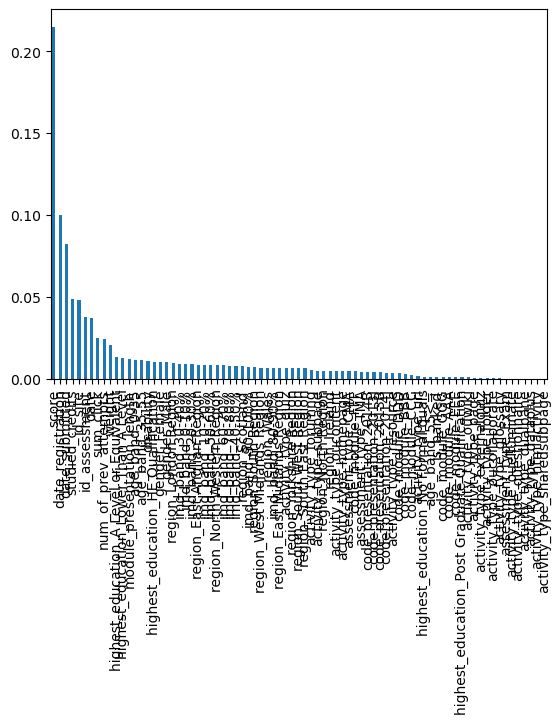

In [29]:
feature_importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

feature_importances.plot.bar();

In [30]:
print(feature_importances.to_string())

score                                            0.214961
date_registration                                0.100067
date_submitted                                   0.082079
studied_credits                                  0.048664
id_site                                          0.048448
id_assessment                                    0.037880
date                                             0.036942
sum_click                                        0.024931
num_of_prev_attempts                             0.024663
weight                                           0.020900
highest_education_A Level or Equivalent          0.013212
highest_education_Lower Than A Level             0.012912
module_presentation_length                       0.011856
age_band_0-35                                    0.011660
age_band_35-55                                   0.011353
disability                                       0.010675
highest_education_HE Qualification               0.010284
gender_Female 

In [31]:
feature_importances.head(10)

score                   0.214961
date_registration       0.100067
date_submitted          0.082079
studied_credits         0.048664
id_site                 0.048448
id_assessment           0.037880
date                    0.036942
sum_click               0.024931
num_of_prev_attempts    0.024663
weight                  0.020900
dtype: float64

In [32]:
feature_importances.tail(10)

activity_type_folder           0.000330
activity_type_oucollaborate    0.000307
activity_type_glossary         0.000261
assessment_type_Exam           0.000221
activity_type_ouelluminate     0.000198
activity_type_questionnaire    0.000103
activity_type_dualpane         0.000093
activity_type_dataplus         0.000063
activity_type_htmlactivity     0.000022
activity_type_sharedsubpage    0.000000
dtype: float64

In [33]:
df_no_with = df_dup_drop[df_dup_drop['final_result'] != 'Withdrawn']
df_no_with['pass'] = np.where(df_no_with['final_result'] == 'Fail', 0, 1)
df = df_no_with.drop(['final_result'], axis = 1)
df.shape

C:\Users\jacob\AppData\Local\Temp\ipykernel_9960\1653742522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_with['pass'] = np.where(df_no_with['final_result'] == 'Fail', 0, 1)


(478805, 24)

In [34]:
df.head()

,id_student,gender,disability,age_band,region,imd_band,highest_education,id_site,code_module,code_presentation,id_assessment,date_registration,num_of_prev_attempts,studied_credits,date_submitted,score,assessment_type,module_presentation_length,weight,is_banked,activity_type,date,sum_click,pass
0,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,forumng,19,1,1
1,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546614,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,homepage,19,10,1
2,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546876,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,subpage,19,2,1
3,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546871,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,subpage,19,1,1
4,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546879,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,subpage,19,3,1


In [42]:
cat_top = ['id_site', 'id_assessment']
rel_top = ['score', 'date_submitted', 'date', 'studied_credits', 'weight', 'date_registration', 'num_of_prev_attempts', 'module_presentation_length']

cat_bottom = ['activity_type', 'highest_education', 'is_banked', 'region', 'code_module']

In [40]:
for i in cat_top:
    table = pd.crosstab(df[i], df['pass']).values
    x_chi = stats.chi2_contingency(table)
    print(i)
    print(f'Chi squared stats: {x_chi.statistic}')
    print(f'Chi squared p-value: {x_chi.pvalue}')
    print(f'Bonferoni corrected alpha: {bon_correct(0.05, x_chi.dof)}')
    if x_chi.pvalue <= bon_correct(0.05, x_chi.dof):
        print(f'Since {x_chi.pvalue} is less than or equal to {bon_correct(0.05, x_chi.dof)}, we reject the null hypothesis in favor of the alternative; that a passing final result may not be independent of {i}.')
    else:
        print(f'Since {x_chi.pvalue} is greater than {bon_correct(0.05, x_chi.dof)}, we accept the null hypothesis that a passing final result may be independent of {i}.')
    print()

id_site
Chi squared stats: 30888.829379904684
Chi squared p-value: 0.0
Bonferoni corrected alpha: 1.0676916506512919e-05
Since 0.0 is less than or equal to 1.0676916506512919e-05, we reject the null hypothesis in favor of the alternative; that a passing final result may not be independent of id_site.

id_assessment
Chi squared stats: 13317.970080194615
Chi squared p-value: 0.0
Bonferoni corrected alpha: 0.00026881720430107527
Since 0.0 is less than or equal to 0.00026881720430107527, we reject the null hypothesis in favor of the alternative; that a passing final result may not be independent of id_assessment.



In [39]:
for i in cat_bottom:
    table = pd.crosstab(df[i], df['pass']).values
    x_chi = stats.chi2_contingency(table)
    print(i)
    print(f'Chi squared stats: {x_chi.statistic}')
    print(f'Chi squared p-value: {x_chi.pvalue}')
    print(f'Bonferoni corrected alpha: {bon_correct(0.05, x_chi.dof)}')
    if x_chi.pvalue <= bon_correct(0.05, x_chi.dof):
        print(f'Since {x_chi.pvalue} is less than or equal to {bon_correct(0.05, x_chi.dof)}, we reject the null hypothesis in favor of the alternative; that a passing final result may not be independent of {i}.')
    else:
        print(f'Since {x_chi.pvalue} is greater than {bon_correct(0.05, x_chi.dof)}, we accept the null hypothesis that a passing final result may be independent of {i}.')
    print()

activity_type
Chi squared stats: 6795.2047770072395
Chi squared p-value: 0.0
Bonferoni corrected alpha: 0.002777777777777778
Since 0.0 is less than or equal to 0.002777777777777778, we reject the null hypothesis in favor of the alternative; that a passing final result may not be independent of activity_type.

highest_education
Chi squared stats: 3146.270765122831
Chi squared p-value: 0.0
Bonferoni corrected alpha: 0.0125
Since 0.0 is less than or equal to 0.0125, we reject the null hypothesis in favor of the alternative; that a passing final result may not be independent of highest_education.

is_banked
Chi squared stats: 144.3950545218273
Chi squared p-value: 2.912184597723841e-33
Bonferoni corrected alpha: 0.05
Since 2.912184597723841e-33 is less than or equal to 0.05, we reject the null hypothesis in favor of the alternative; that a passing final result may not be independent of is_banked.

region
Chi squared stats: 3477.8533017542045
Chi squared p-value: 0.0
Bonferoni corrected alp

score


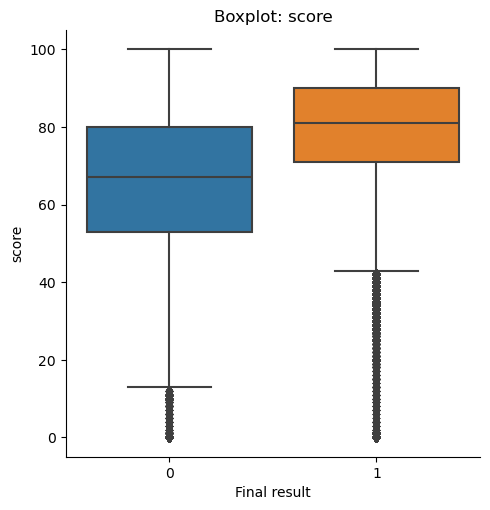

Overall
Mean: 76.45813013648562
Std: 17.46568455978133
Median: 80.0
Quartiles: 0.25    67.0
0.75    89.0
Name: score, dtype: float64

Passed
Mean: 79.276574972273
Std: 15.535057671358189
Median: 81.0
Quartiles: 0.25    71.0
0.75    90.0
Name: score, dtype: float64

Failed
Mean: 65.02691572600656
Std: 20.014248686650095
Median: 67.0
Quartiles: 0.25    53.0
0.75    80.0
Name: score, dtype: float64

date_submitted


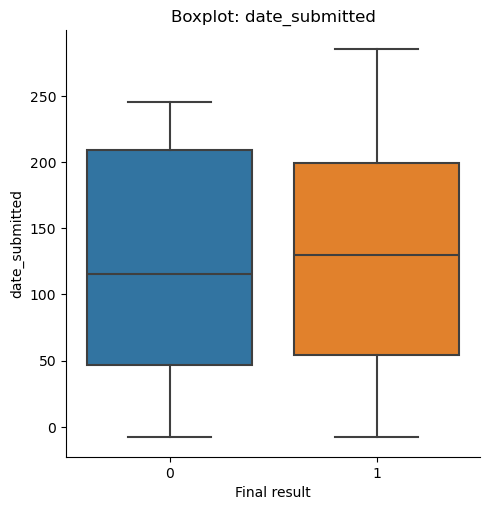

Overall
Mean: 125.6617579181504
Std: 74.78874918169082
Median: 128.0
Quartiles: 0.25     53.0
0.75    199.0
Name: date_submitted, dtype: float64

Passed
Mean: 126.9486829019375
Std: 73.2389295080969
Median: 130.0
Quartiles: 0.25     54.0
0.75    199.0
Name: date_submitted, dtype: float64

Failed
Mean: 120.44217184249707
Std: 80.56017362938022
Median: 115.0
Quartiles: 0.25     47.0
0.75    209.0
Name: date_submitted, dtype: float64

date


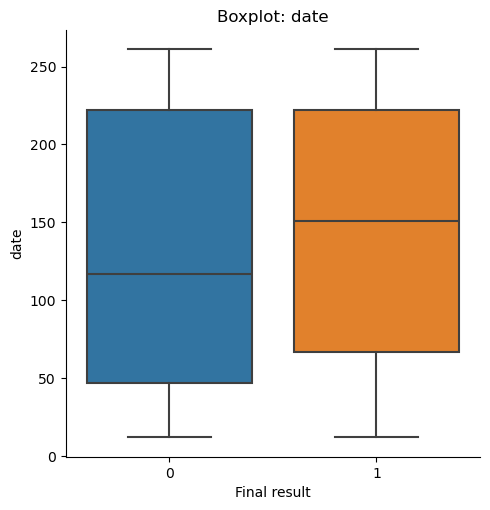

Overall
Mean: 140.4101920406011
Std: 79.83633255626557
Median: 144.0
Quartiles: 0.25     54.0
0.75    222.0
Name: date, dtype: float64

Passed
Mean: 143.7256509989534
Std: 78.52965327170338
Median: 151.0
Quartiles: 0.25     67.0
0.75    222.0
Name: date, dtype: float64

Failed
Mean: 126.96315850606634
Std: 83.59305640932419
Median: 117.0
Quartiles: 0.25     47.0
0.75    222.0
Name: date, dtype: float64

studied_credits


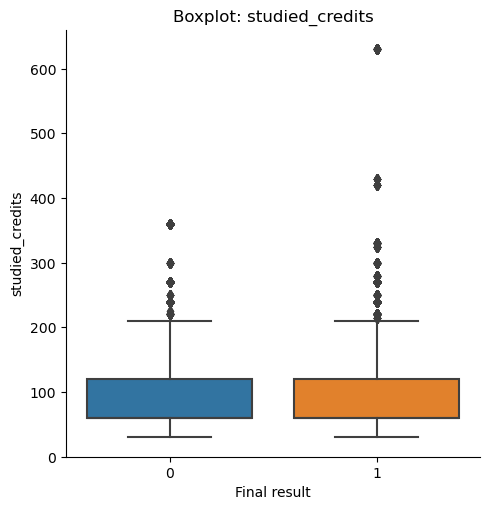

Overall
Mean: 81.88743851881246
Std: 39.62672499368685
Median: 60.0
Quartiles: 0.25     60.0
0.75    120.0
Name: studied_credits, dtype: float64

Passed
Mean: 81.05348318936116
Std: 37.83224791201701
Median: 60.0
Quartiles: 0.25     60.0
0.75    120.0
Name: studied_credits, dtype: float64

Failed
Mean: 85.26984361635851
Std: 46.04122613811498
Median: 60.0
Quartiles: 0.25     60.0
0.75    120.0
Name: studied_credits, dtype: float64

weight


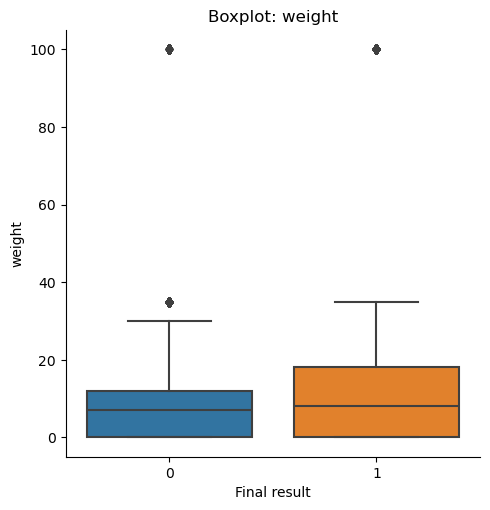

Overall
Mean: 9.975505686030848
Std: 10.882838784212518
Median: 8.0
Quartiles: 0.25     0.0
0.75    18.0
Name: weight, dtype: float64

Passed
Mean: 10.321274036584033
Std: 11.204223899274497
Median: 8.0
Quartiles: 0.25     0.0
0.75    18.0
Name: weight, dtype: float64

Failed
Mean: 8.573118063841694
Std: 9.337840182625854
Median: 7.0
Quartiles: 0.25     0.0
0.75    12.0
Name: weight, dtype: float64

date_registration


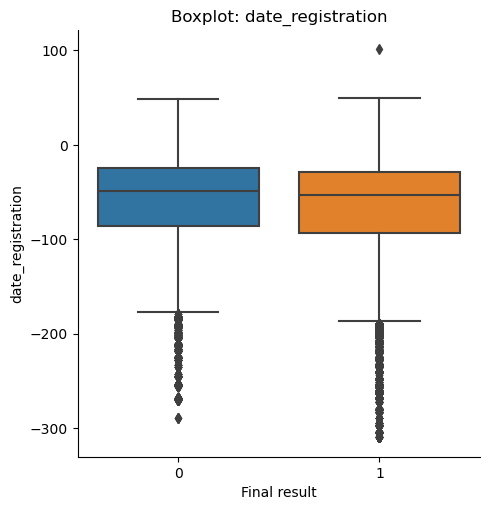

Overall
Mean: -64.70967304017293
Std: 46.18038799594558
Median: -52.0
Quartiles: 0.25   -92.0
0.75   -28.0
Name: date_registration, dtype: float64

Passed
Mean: -65.6495410073366
Std: 46.45643276566365
Median: -53.0
Quartiles: 0.25   -93.0
0.75   -29.0
Name: date_registration, dtype: float64

Failed
Mean: -60.897701234385394
Std: 44.842165452038195
Median: -49.0
Quartiles: 0.25   -86.0
0.75   -25.0
Name: date_registration, dtype: float64

num_of_prev_attempts


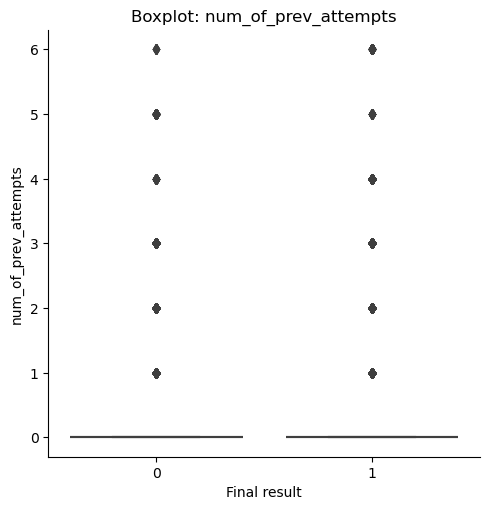

Overall
Mean: 0.1616837752320882
Std: 0.4698632185457454
Median: 0.0
Quartiles: 0.25    0.0
0.75    0.0
Name: num_of_prev_attempts, dtype: float64

Passed
Mean: 0.14259753919531792
Std: 0.4404958436232293
Median: 0.0
Quartiles: 0.25    0.0
0.75    0.0
Name: num_of_prev_attempts, dtype: float64

Failed
Mean: 0.23909485443966927
Std: 0.5672190049146887
Median: 0.0
Quartiles: 0.25    0.0
0.75    0.0
Name: num_of_prev_attempts, dtype: float64

module_presentation_length


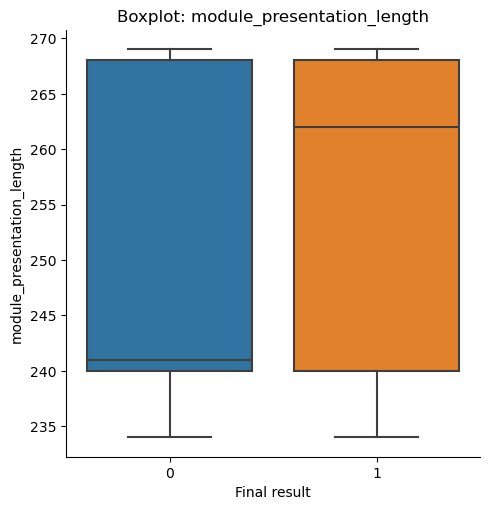

Overall
Mean: 255.04664947107904
Std: 13.78612940032734
Median: 261.0
Quartiles: 0.25    240.0
0.75    268.0
Name: module_presentation_length, dtype: float64

Passed
Mean: 255.50180420825717
Std: 13.772146688711398
Median: 262.0
Quartiles: 0.25    240.0
0.75    268.0
Name: module_presentation_length, dtype: float64

Failed
Mean: 253.2006061054032
Std: 13.688466282065871
Median: 241.0
Quartiles: 0.25    240.0
0.75    268.0
Name: module_presentation_length, dtype: float64



In [56]:
for i in rel_top:
    print(i)
    _ = sns.catplot(x = 'pass', y = i, data = df, kind = 'box')
    _ = plt.xlabel('Final result')
    _ = plt.ylabel(f'{i}')
    _ = plt.title(f'Boxplot: {i}')
    plt.show()
    print('Overall')
    print(f'Mean: {df[i].mean()}')
    print(f'Std: {df[i].std()}')
    print(f'Median: {df[i].median()}')
    print(f'Quartiles: {df[i].quantile([0.25, 0.75])}')
    print()
    print('Passed')
    print(f'Mean: {df[df['pass'] == 1][i].mean()}')
    print(f'Std: {df[df['pass'] == 1][i].std()}')
    print(f'Median: {df[df['pass'] == 1][i].median()}')
    print(f'Quartiles: {df[df['pass'] == 1][i].quantile([0.25, 0.75])}')
    print()
    print('Failed')
    print(f'Mean: {df[df['pass'] == 0][i].mean()}')
    print(f'Std: {df[df['pass'] == 0][i].std()}')
    print(f'Median: {df[df['pass'] == 0][i].median()}')
    print(f'Quartiles: {df[df['pass'] == 0][i].quantile([0.25, 0.75])}')
    print()